# Hyper Parameter Tuning 


#### By Deirdree A. Polak - github dapolak
Imperial College London
MSc Applied Imperial Sciences and Engineering

August 2019

## Import Relevant Packages

In [3]:
runtime=spark.conf.get("spark.databricks.clusterUsageTags.sparkVersion")
if "-ml-" not in runtime:
  dbutils.library.install("dbfs:/FileStore/jars/49037586_d162_4365_a6ba_9b25277b75c8/slugdetection-0.0.1-py3-none-any.whl") # FileStor location and name of package
  #dbutils.library.installPyPI("")
  dbutils.library.restartPython()

In [4]:
from slugdetection import *

In [5]:
# General imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# Pyspark imports
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, TimestampType
from pyspark.sql.window import Window

# Scikit Learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Time Series Analysis imports
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## Load Data

If this is run from DataBricks directly, the following code can be run. The tables need to be pre-loaded in the database

In [7]:
# From original well_wh_choke table in database, select the timestamp and wh_choke values
WH_choke = spark.table("well_wh_choke").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("WH_choke"),
  )
# From original well_dh_p table in database, select the timestamp and wh_choke values
DH_P = spark.table("well_dh_p").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("DH_P"),
  )
# From original well_wh_p table in database, select the timestamp and wh_choke values
WH_P = spark.table("well_wh_p").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("WH_P"),
  )
# From original well_dh_t table in database, select the timestamp and wh_choke values
DH_T = spark.table("well_dh_t").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("DH_T"),
  )
# From original well_wh_t table in database, select the timestamp and wh_choke values
WH_T = spark.table("well_wh_t").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("WH_T"),
  )

In [8]:
# Join the individual tables into one spark dataframe. 
data_spark = WH_P.join(DH_P, 'ts', how='full').join(DH_T, "ts", how='full').join(WH_T, "ts", how='full').join(WH_choke, "ts", how='full')

## Data Cleaning 

Before any analysis can take place, the data needs to be cleaned for missing values and out of bound values.

Pre data analysis

In [11]:
well = Data_Engineering(data_spark) # A data instance is created. The data frame is now an pbject
well.timeframe(start="01-JAN-10 09:09") # Data can be clipped for time
well.data_range() # The five streams of data WHP, DHP, WHT, DHT and WH choke are thresholded
pd_df = well.df_toPandas()

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]
Converting Spark data frame to Pandas
Converted

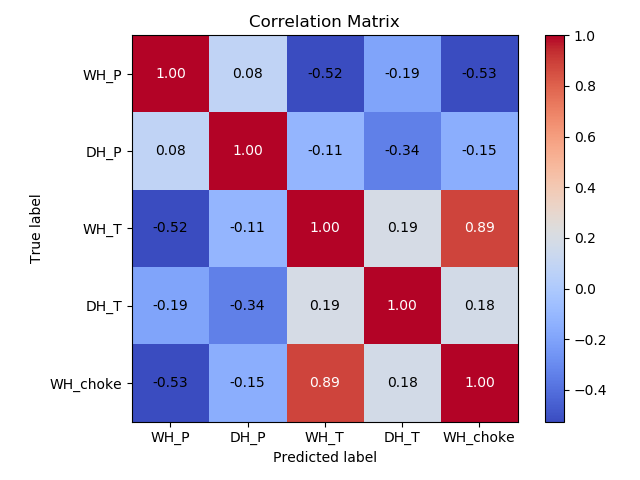

In [12]:
labels = pd_df.corr().columns
corre = pd_df.corr().values
plot = confusion_mat(corre, labels, title='Correlation Matrix', cmap='coolwarm')
display(plot)

From this correlation plot, it can be seen that the Well Head variables WHP, WHT and WHchoke are most correlated. DHT scores low for correlation with any of hte other variables.

# Slug Detection HyperParameter Tuning

Hyper parameter tuning was performed to decide on the best values for the following parameters:

Random Forest Hyper Parameters: 

- Number of Trees (n_estimators) 
- Depth of Trees(max_depth) and, 
- Bootstrap (whether columns/rows are dropped per Decision Tree)(bootstrap)

Logistics Regression: 
- Regularization value (C) and,
- Maximum iteration number (max_iter)

Data Engineering Method: 
- Window size (default 5 hours) and 
- Number of splits (default 5) in Feature Vectors

In [15]:
# Clean Data and convert
sd = Slug_Detection(data_spark)
sd.timeframe(start="01-JAN-14 09:09", end="30-SEP-18 09:09")
sd.data_range()
sd.clean_choke(method = "99")
pd_df = sd.df_toPandas()

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]
Converting Spark data frame to Pandas
Converted

In [16]:
# All the data formatting has been regrouped in one function, and any argument can be passed in as kwargs
sd.data_prep(max_clean_count = 500, standardise=True)

## Hyperparameter Tuning Random Forest Model#

In [18]:
# reset X_train and X_test with full features
sd.feature_vector(standardise=True)

sd.split_data() # split the data again

In [19]:
n_estimators = [5, 10, 15, 20] #default is 10
max_depth = [None, 50, 10, 5, 2] #default is None
bootstrap = [True, False] # default is true

parameter_grid = dict(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap)

In [20]:
RF = RandomForestClassifier()
grid = GridSearchCV(estimator=RF, param_grid=parameter_grid, cv = 3, return_train_score=True)

grid_result = grid.fit(sd.X_train, sd.y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.993534 using {'bootstrap': True, 'max_depth': None, 'n_estimators': 15}

The best hyper parameters were selected to be 
- bootstrap: True, 
- max_depth: None, and
- n_estimators: 15

## Hyperparameter Tuning Logisitics Regression model

In [22]:
# reset X_train and X_test with full features
sd.feature_vector(standardise=True)

sd.split_data() # split the data again

C = [0.01, 0.1, 0.5, 1.0, 2.0] #default is 1.0
max_iter = [50, 75, 90, 100, 110, 120, 150] #default is 100

parameter_grid = dict(C=C, max_iter=max_iter)

In [23]:
lr = LogisticRegression()
grid = GridSearchCV(estimator=lr, param_grid=parameter_grid, cv = 3, return_train_score=True)

grid_result = grid.fit(sd.X_train, sd.y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.954741 using {'C': 1.0, 'max_iter': 50}

The best hyperparameters are C=1.0 and max_iter = 50

This was compared with the performance of the Logistics Regression using only the 15 best features, as ranked by Random Forest

## Hyperparameter Tuning Logisitics Regression model with top features

In [25]:
RF = RandomForestClassifier(bootstrap = True, max_depth = None, n_estimators=15)
RF.fit(sd.X_train, sd.y_train)
ranked_features = RF.feature_importances_
top_features = sd.feature_selection(ranked_features, top_n=50) # from the perdiction feature importance list, extract the top 50 features
print(top_features)

sd.X_train = sd.X_train[[*top_features]]

['std_DH_P_4', 'std_WH_P_2', 'std_WH_P_4', 'std_WH_P_1', 'mean_DH_P_1', 'num_mean_DH_P_sign_decr', 'std_DH_T_3', 'diff_mean_signif_DH_P_2_3', 'std_WH_T_4', 'std_WH_T_1', 'num_mean_DH_P_sign_incr', 'std_DH_T_4', 'diff_mean_signif_DH_P_0_1', 'std_DH_P_1', 'num_mean_WH_P_sign_incr']

In [26]:
lr = LogisticRegression()
grid = GridSearchCV(estimator=lr, param_grid=parameter_grid, cv = 3, n_jobs=-1)

grid_result = grid.fit(sd.X_train, sd.y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.956897 using {'C': 2.0, 'max_iter': 50}

The best hyperparameters are C=2.0 and max_iter = 50

Next the model was tuned using the new hyper parameters for the Random Forest. A grid search was manuallyy performed to compare the scores of three different list size (how manyhours to take as flow leading to slug flow) and three different window split (how many split in the window of time or how many )

## Hyperparameter Tuning Methodology

In [28]:
hyper = Slug_Detection(data_spark)
hyper.timeframe(start="01-JAN-14 09:09", end="30-SEP-18 09:09")
hyper.data_range()
hyper.clean_choke(method = "99")
pd_df = hyper.df_toPandas()


WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [0, 100]
Converting Spark Dataframe to Pandas
Converted

In [29]:

size_list = [240, 300, 360]
window_size = [4, 5, 6]

scores = []
for sl in size_list:
  for ws in window_size:
    hyper.data_prep(size_list=sl, window_size=ws, standardise=False)
    pred_f = hyper.RF_train() 
    rf_pred, rf_score, rf_cm = hyper.RF_predict(true_label = True) 
    scores.append(rf_score)
    print("Window size:", sl, "Number of Splits:", ws, "% Score:",  round(rf_score*100, 3))

# fig, ax = plt.subplots(1, 1)
# ax.plot()

Window size: 240 Number of Splits: 4 % Score: 98.795
Window size: 240 Number of Splits: 5 % Score: 98.193
Window size: 240 Number of Splits: 6 % Score: 98.494
Window size: 300 Number of Splits: 4 % Score: 98.063
Window size: 300 Number of Splits: 5 % Score: 98.708
Window size: 300 Number of Splits: 6 % Score: 98.801
Window size: 360 Number of Splits: 4 % Score: 98.371
Window size: 360 Number of Splits: 5 % Score: 98.48
Window size: 360 Number of Splits: 6 % Score: 97.72

Overall, by performing this search grid couple of times, the results seem to indicate that 240 and 300 points long interval performs better than a 360 one. For practical reson, 240 minutes interval is chosen over 300. With a shorter interval, more slug flow data is likely to be sourced from the raw data, as the requirements (shorter continous set) are relaxed.

The number of splits in the continous data is not conclusive, and will therefore be kept at 5 splits.

# Slug Forecasting Parameter Selection


In this section different parameters are tested on slug flow to produce the best fit.

In [32]:
whp = Data_Engineering(data_spark)
whp.timeframe(start="01-JAN-16 09:09", end="30-NOV-18 09:09")
whp.data_range()
whp.features= ["WH_P"] # override
WHP_ = whp.df_toPandas()

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]
Converting Spark data frame to Pandas
Converted

In [33]:
WHP = WHP_[3000:3250].copy() # Clean data frame

In [34]:
sf = Slug_Forecasting(WHP.copy()) # Instantiate Slug_Foreactsing class with pandas dataframe
sf.stationarity_check(diff=0) # Check data is stationary. It should be if it is a a slug flow.
sf.split_data(train_size = 180, predict_size = 60) # split data

ADF Statistic: -4.192408
p-value: 0.000679
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573

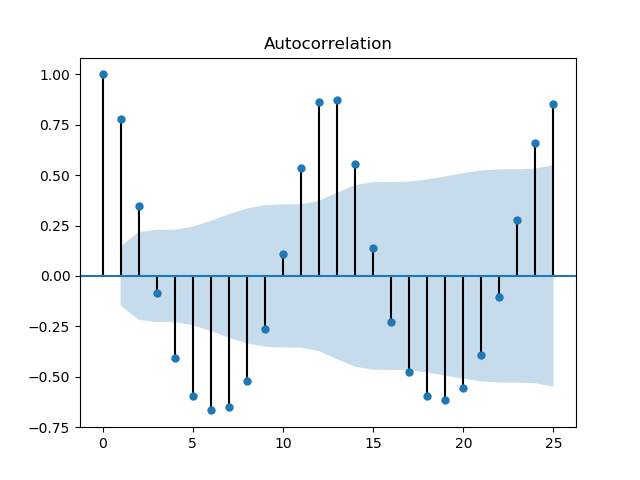

In [35]:
plot = sf.autocorrelation_plot()
display(plot)

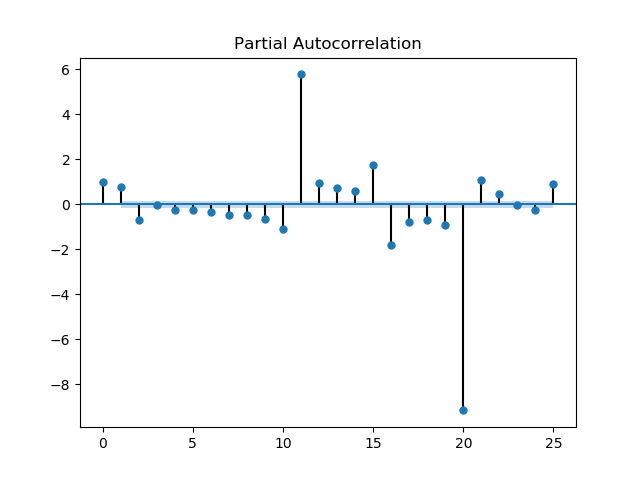

In [36]:
plot = sf.partial_autocorrelation_plot()
display(plot)

### Parameter p = 1, d =0, q = 1 are tried first.

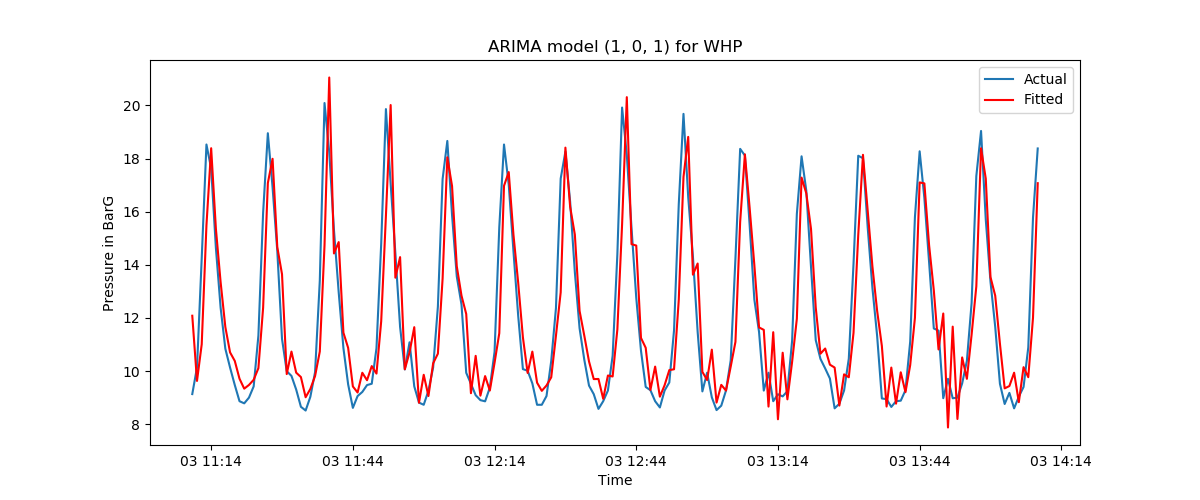

In [38]:
plot = sf.ARIMA_model(1, 0, 1)
display(plot)

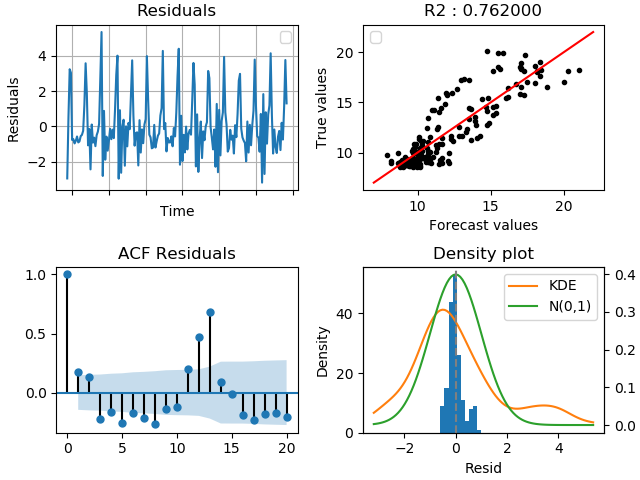

In [39]:
plot = sf.error_metrics_plot(error="fit")
display(plot)

In [40]:
sf.error_metrics(error="fit")

Mean Absolute Percentage Error: -1.655
Mean Squared Error: 2.741000
Root Mean Squared Error: 1.656000
R2 Determination: 0.762000
Out[27]: (-1.655, 2.741, 1.656, 0.762)

It is noticeable from the fitting plot that the ARIMA model is actually fitting the slug curve a t+1 = t . The fll curve is shifted one minute in time. This is also shown in the error infographics where the density function has its mean at -1. The residuals are corrlated and have a pattern.

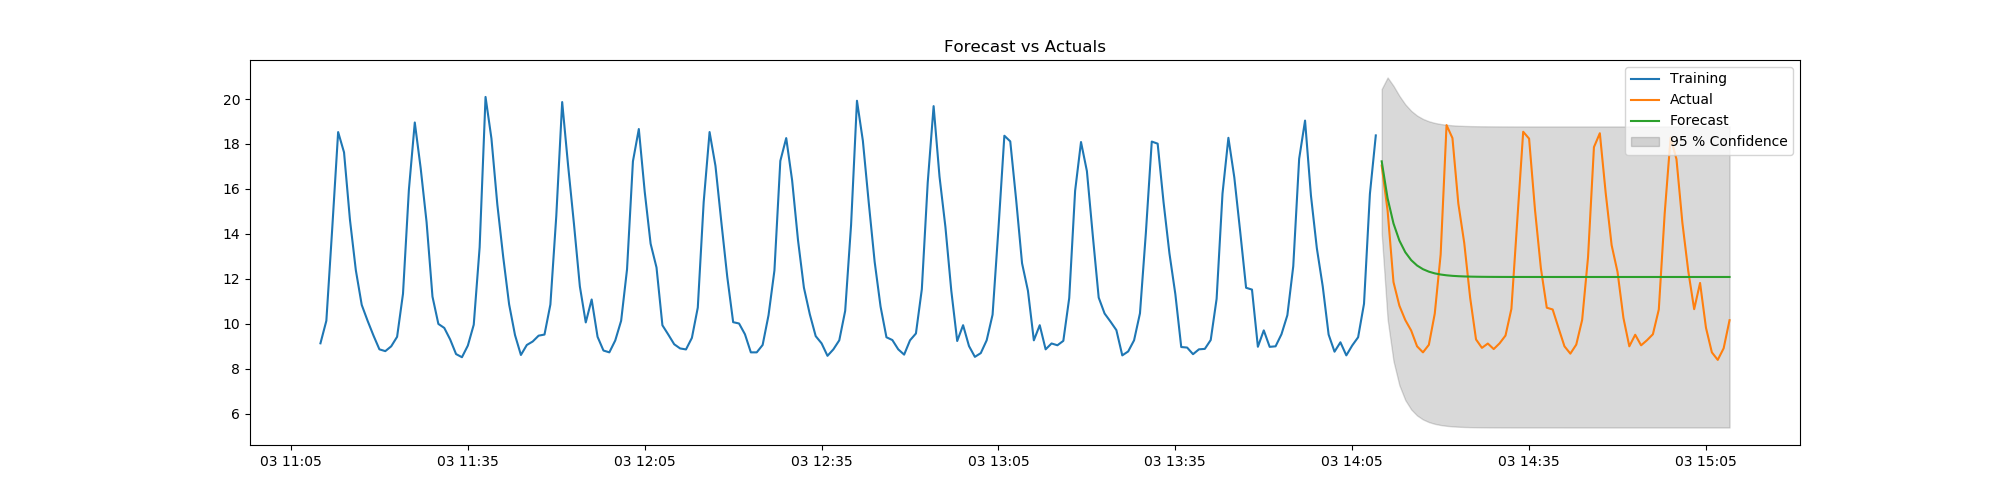

In [42]:
plot = sf.ARIMA_pred(pred_time=60)
display(plot)

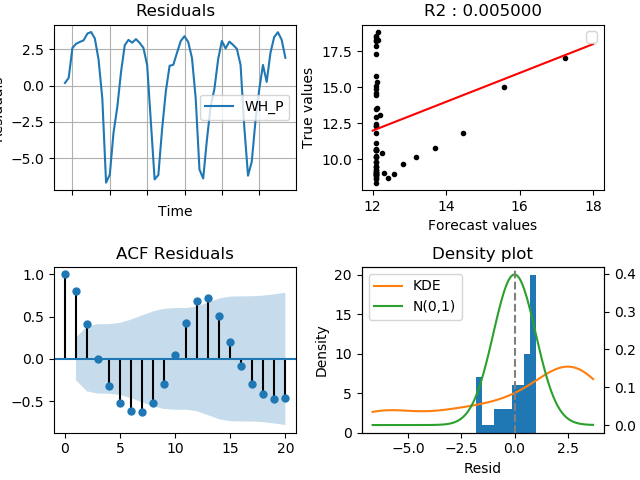

In [43]:
plot = sf.error_metrics_plot(error="pred")
display(plot)

looking at the prediction fit, it is clear that ARIMA(1,0,1) is not complex enough to fit the data.


### Comparing it to parameters p=11, d = 0, q=4

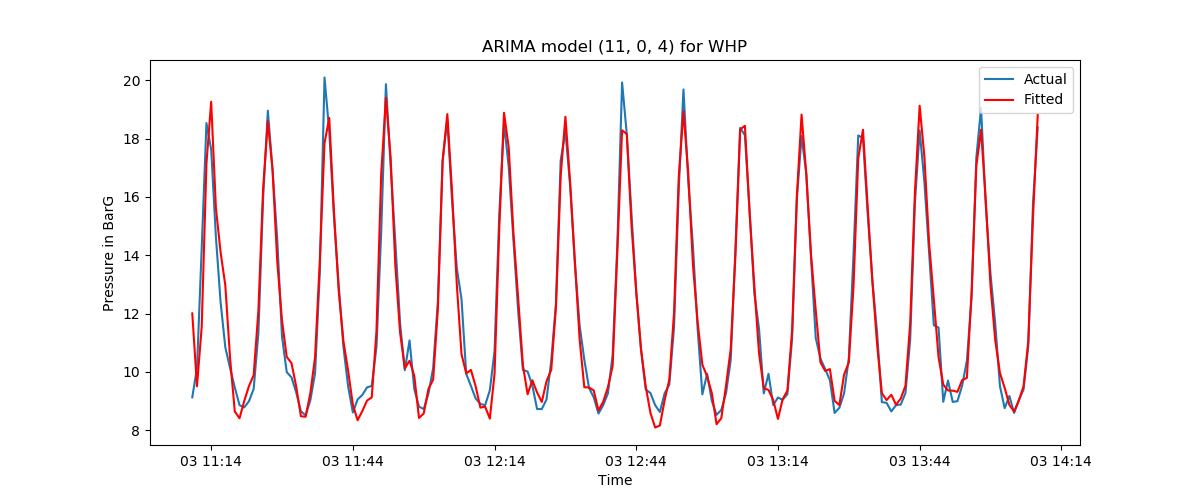

In [45]:
plot = sf.ARIMA_model(11, 0, 4)
display(plot)

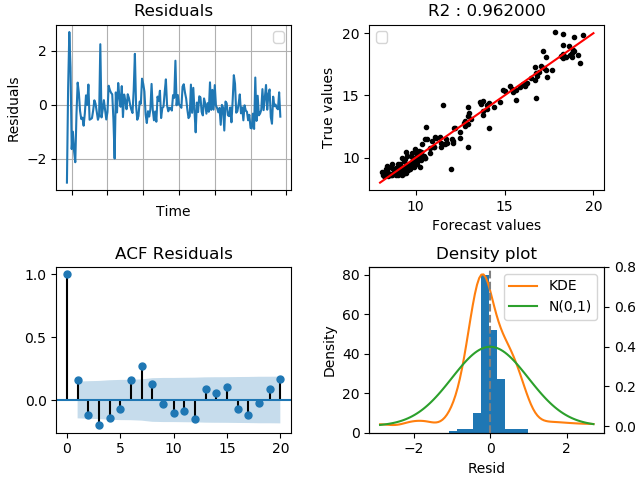

In [46]:
plot = sf.error_metrics_plot(error="fit")
display(plot)

In [47]:
sf.error_metrics(error="fit")

Mean Absolute Percentage Error: -0.365
Mean Squared Error: 0.437000
Root Mean Squared Error: 0.661000
R2 Determination: 0.962000
Out[32]: (-0.365, 0.437, 0.661, 0.962)

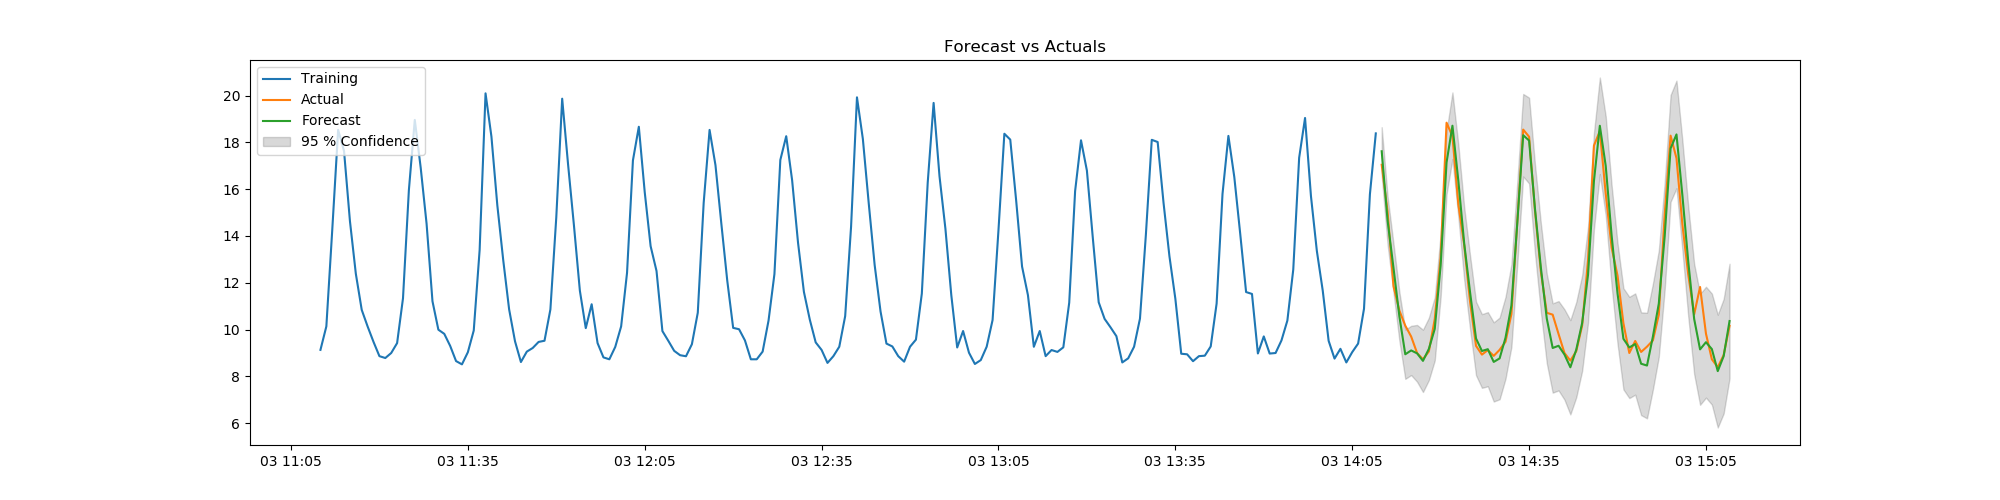

In [48]:
plot = sf.ARIMA_pred(pred_time=60)
display(plot)

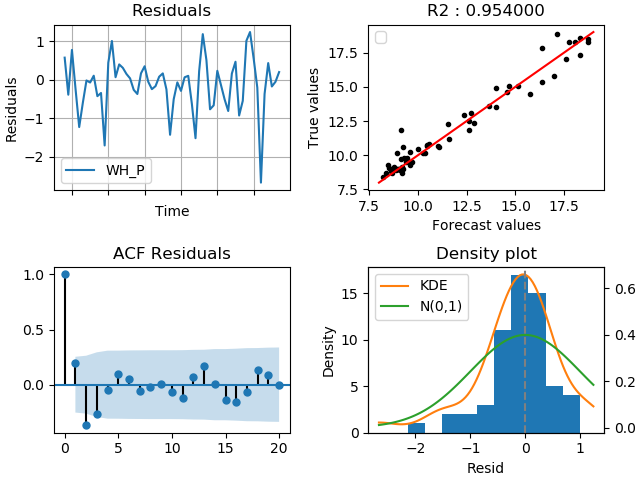

In [49]:
plot = sf.error_metrics_plot(error="pred")
display(plot)

The ARIMA(11, 0, 4) offers a much better fit to the data. The added complexity which reflects of the cyclicity of the wells occuring every 10-12 minutes here allows for a better fit and an acceptable forecast. It can be seen that the confidence interval at the peaks and trough of the slug is still quite high, but the frequancy of the slugs is right.

### Finally an ARIMA(11, 0,11) will be tested:

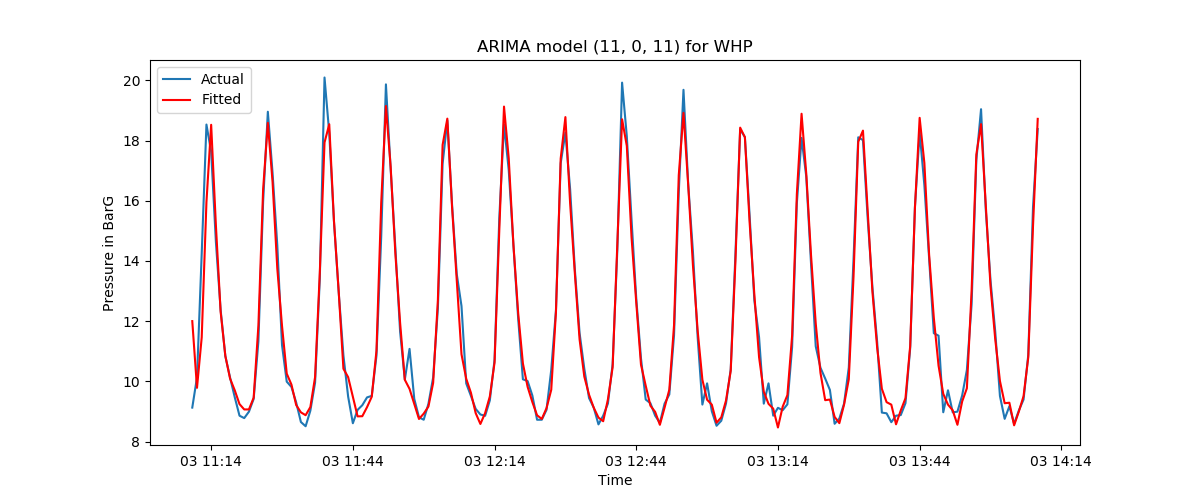

In [51]:
plot = sf.ARIMA_model(11, 0, 11)
display(plot)

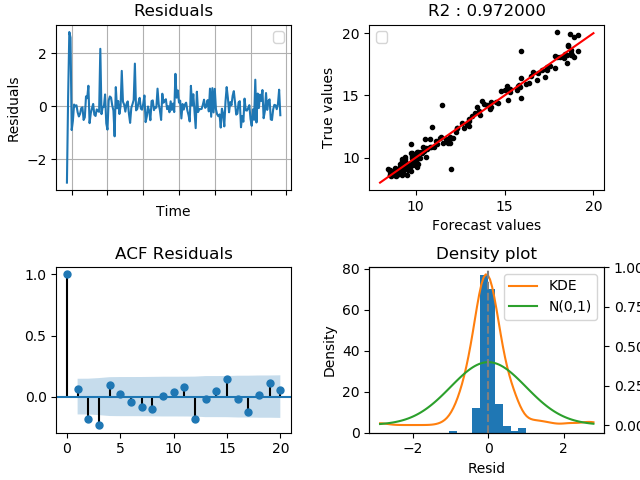

In [52]:
plot = sf.error_metrics_plot(error="fit")
display(plot)

In [53]:
sf.error_metrics(error="fit")

Mean Absolute Percentage Error: -0.131
Mean Squared Error: 0.321000
Root Mean Squared Error: 0.566000
R2 Determination: 0.972000
Out[39]: (-0.131, 0.321, 0.566, 0.972)

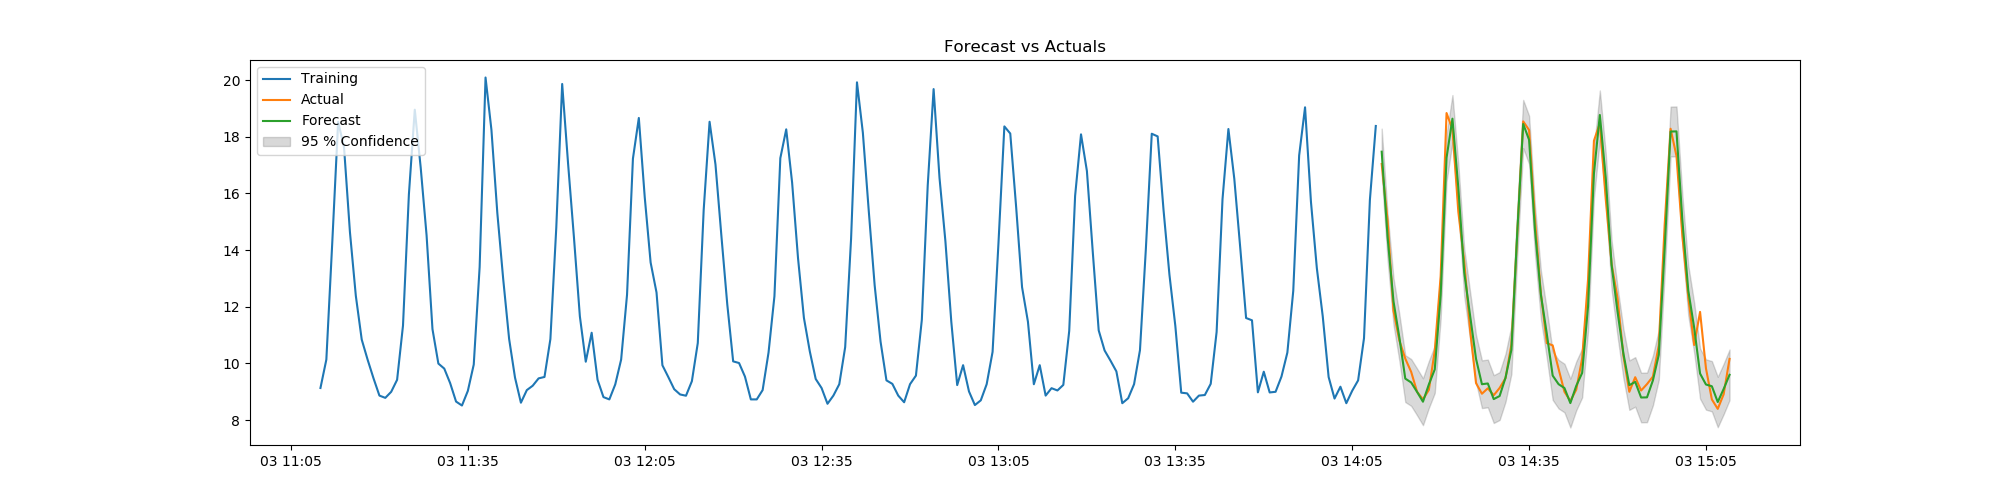

In [54]:
plot = sf.ARIMA_pred(pred_time=60)
display(plot)

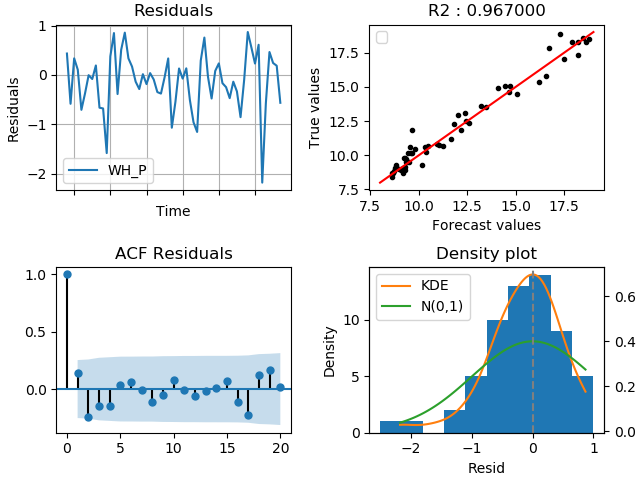

In [55]:
plot = sf.error_metrics_plot(error="pred")
display(plot)

Arima(11, 0, 11) is the best of all three models tested. Same as ARIMA(11, 0, 4) it predicts the frequency of slugs accurately, and the confidence interval at the troughs and peaks is reduced. 

Looking at another slug interval:

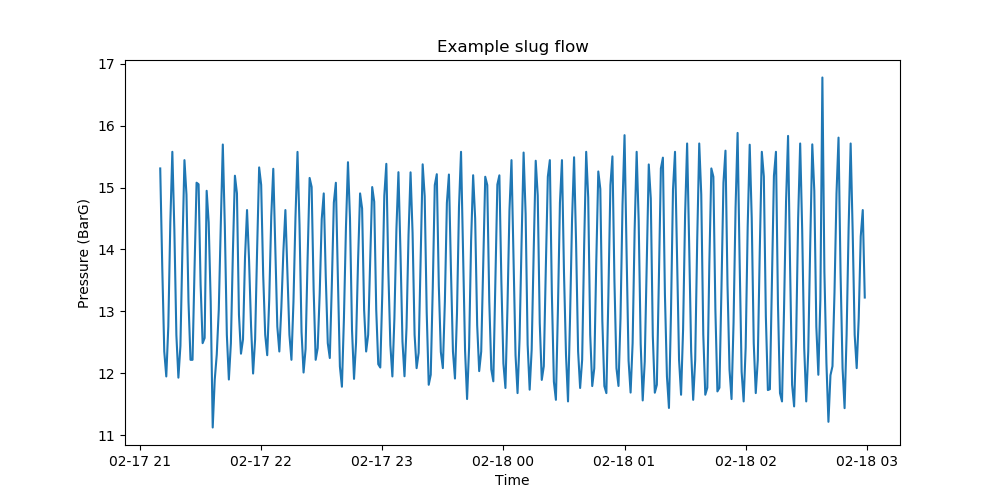

In [57]:
# Check sluf flow behaviour
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(WHP_[68400:68750]['ts'], WHP_[68400:68750]['WH_P'], 'C0-')
ax.set_title("Example slug flow")
ax.set_xlabel("Time")
ax.set_ylabel("Pressure (BarG)")
display(f)

In [58]:
WHP = WHP_[68400:68750].copy() # Clean data frame

In [59]:
sf = Slug_Forecasting(WHP.copy()) # Instantiate Slug_Foreactsing class with pandas dataframe
sf.stationarity_check(diff=0) # Check data is stationary. It should be if it is a a slug flow.
sf.split_data(train_size = 180, predict_size = 60) # split data

ADF Statistic: -4.773101
p-value: 0.000061
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571

Data is stationary, no differencing is required

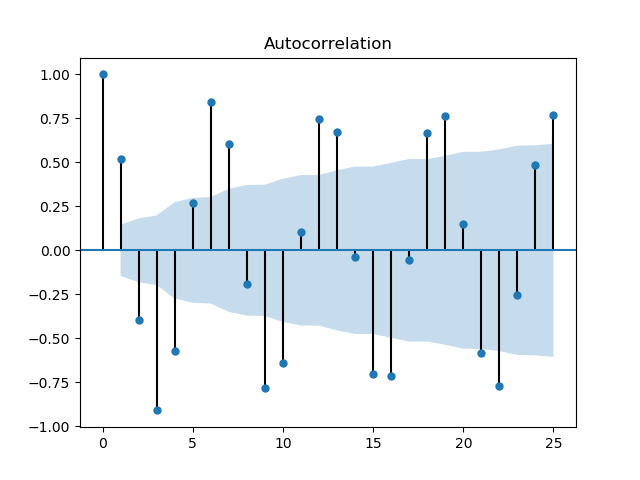

In [61]:
plot = sf.autocorrelation_plot()
display(plot)

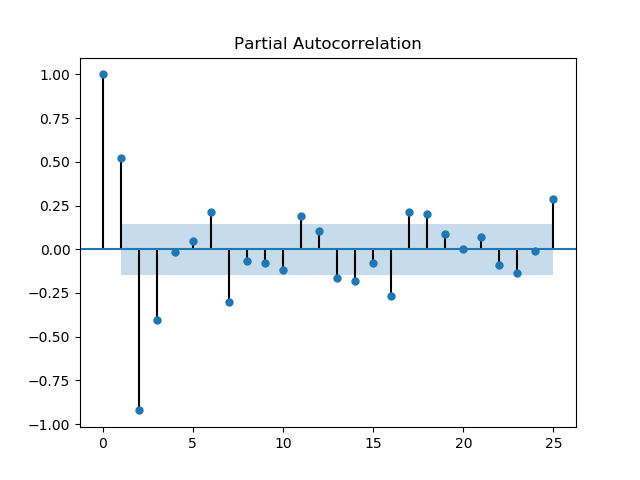

In [62]:
plot = sf.partial_autocorrelation_plot()
display(plot)

From the PACf and ACf plot, it can be estimatatd that p = 2 and q = 1, 2, 3 or 6

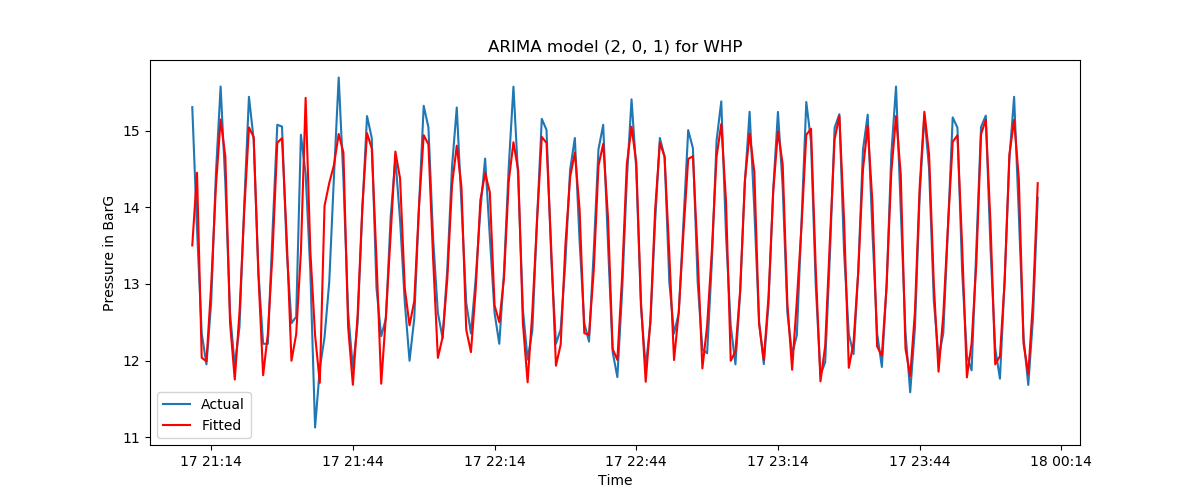

In [64]:
plot = sf.ARIMA_model(2, 0, 1)
display(plot)

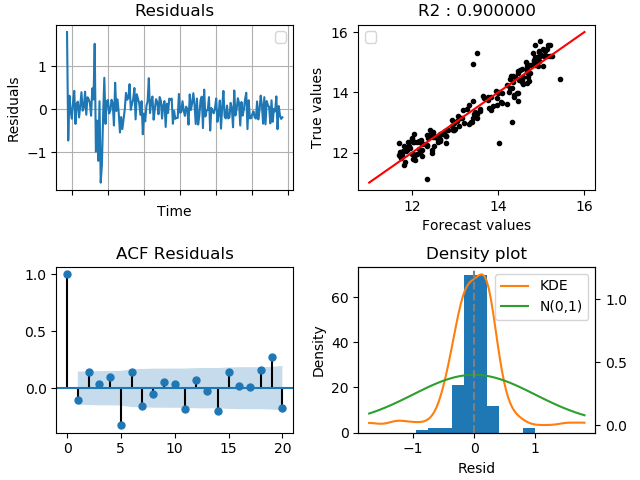

In [65]:
plot = sf.error_metrics_plot(error="fit")
display(plot)

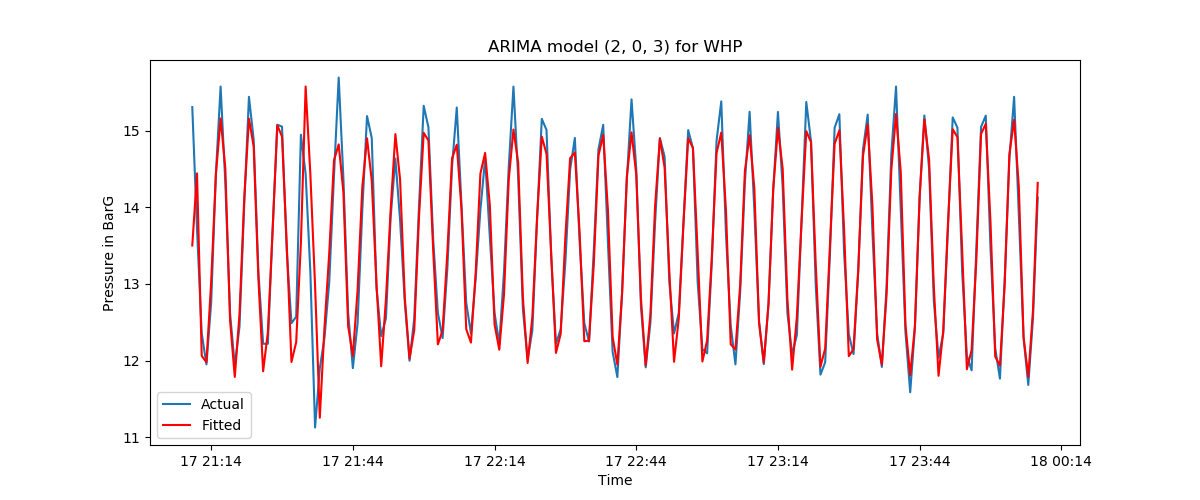

In [66]:
plot = sf.ARIMA_model(2, 0, 3)
display(plot)

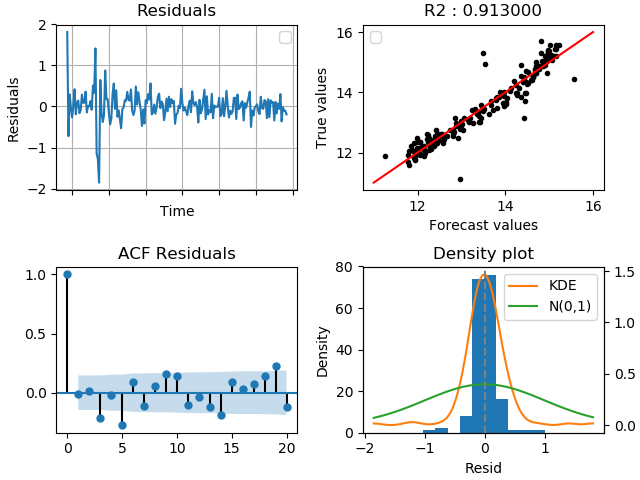

In [67]:
plot = sf.error_metrics_plot(error="fit")
display(plot)

In [68]:
sf.error_metrics(error="fit")

Mean Absolute Percentage Error: -0.022
Mean Squared Error: 0.122000
Root Mean Squared Error: 0.349000
R2 Determination: 0.913000
Out[73]: (-0.022, 0.122, 0.349, 0.913)

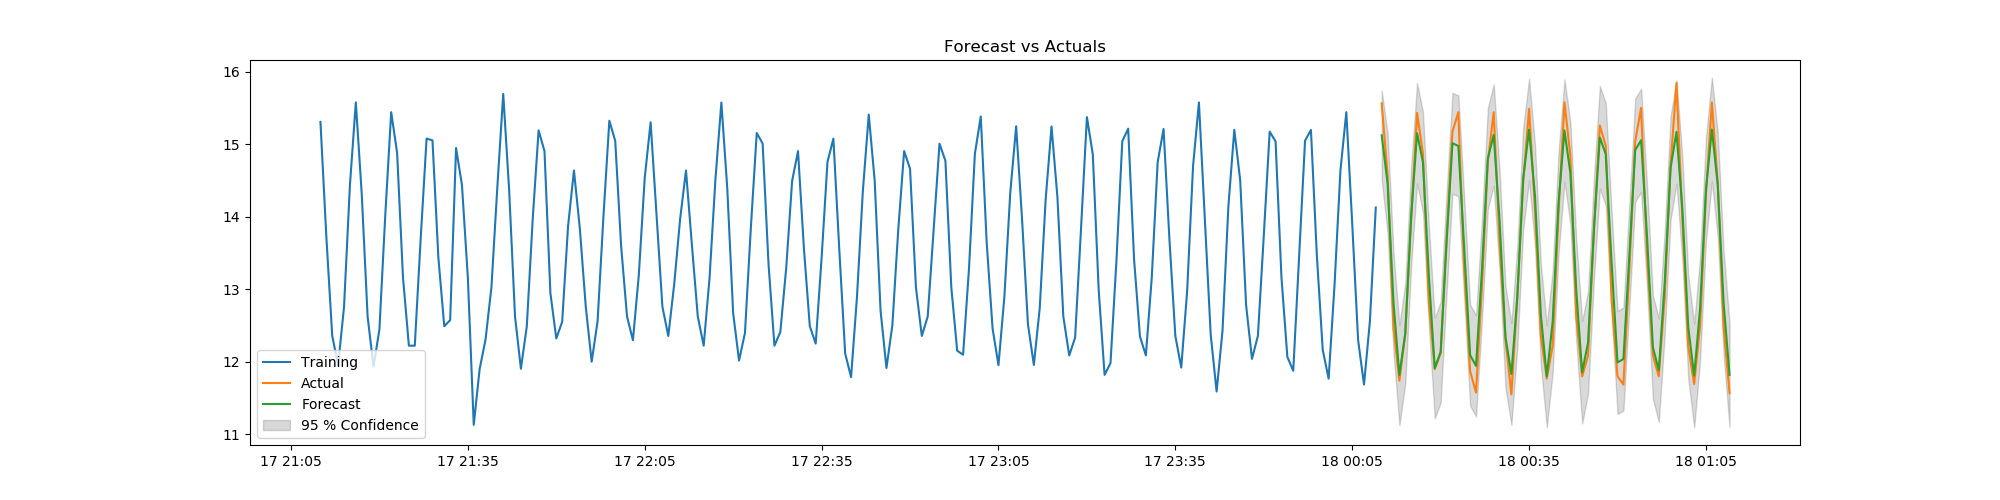

In [69]:
plot = sf.ARIMA_pred(pred_time=60)
display(plot)

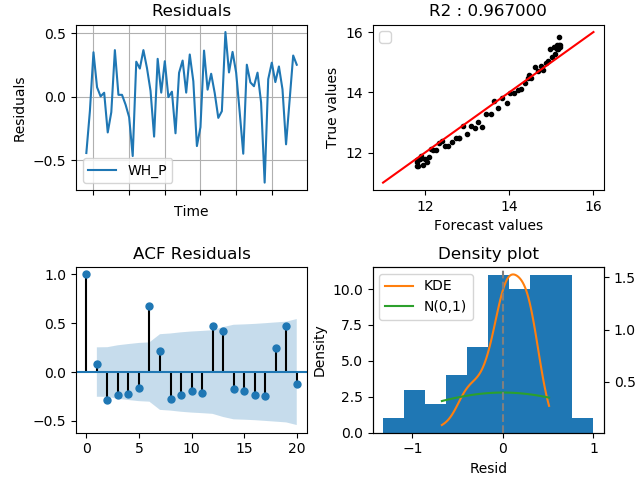

In [70]:
plot = sf.error_metrics_plot(error="pred")
display(plot)

The results are still correlated as can be seen in the ACF residual plot.

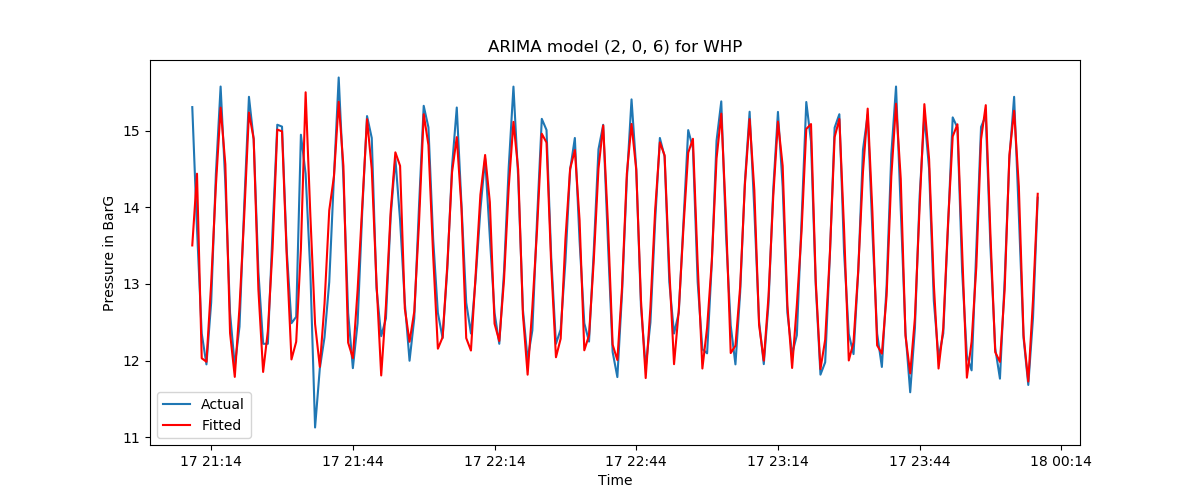

In [72]:
plot = sf.ARIMA_model(2, 0, 6)
display(plot)

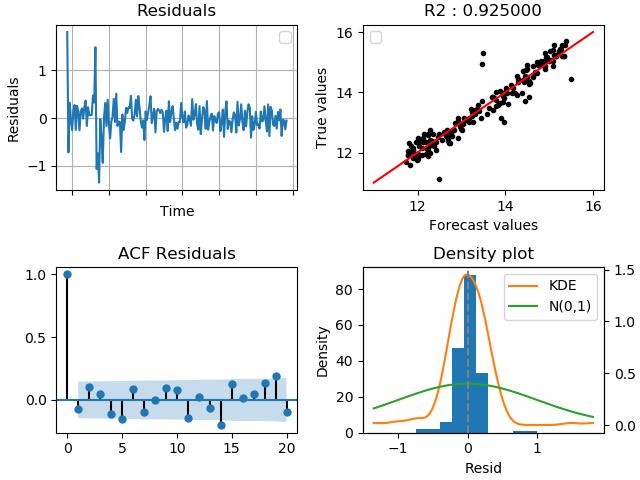

In [73]:
plot = sf.error_metrics_plot(error="fit")
display(plot)

In [74]:
sf.error_metrics(error="fit")

Mean Absolute Percentage Error: -0.002
Mean Squared Error: 0.105000
Root Mean Squared Error: 0.324000
R2 Determination: 0.925000
Out[78]: (-0.002, 0.105, 0.324, 0.925)

these are the best scores so far dor this slug flow.

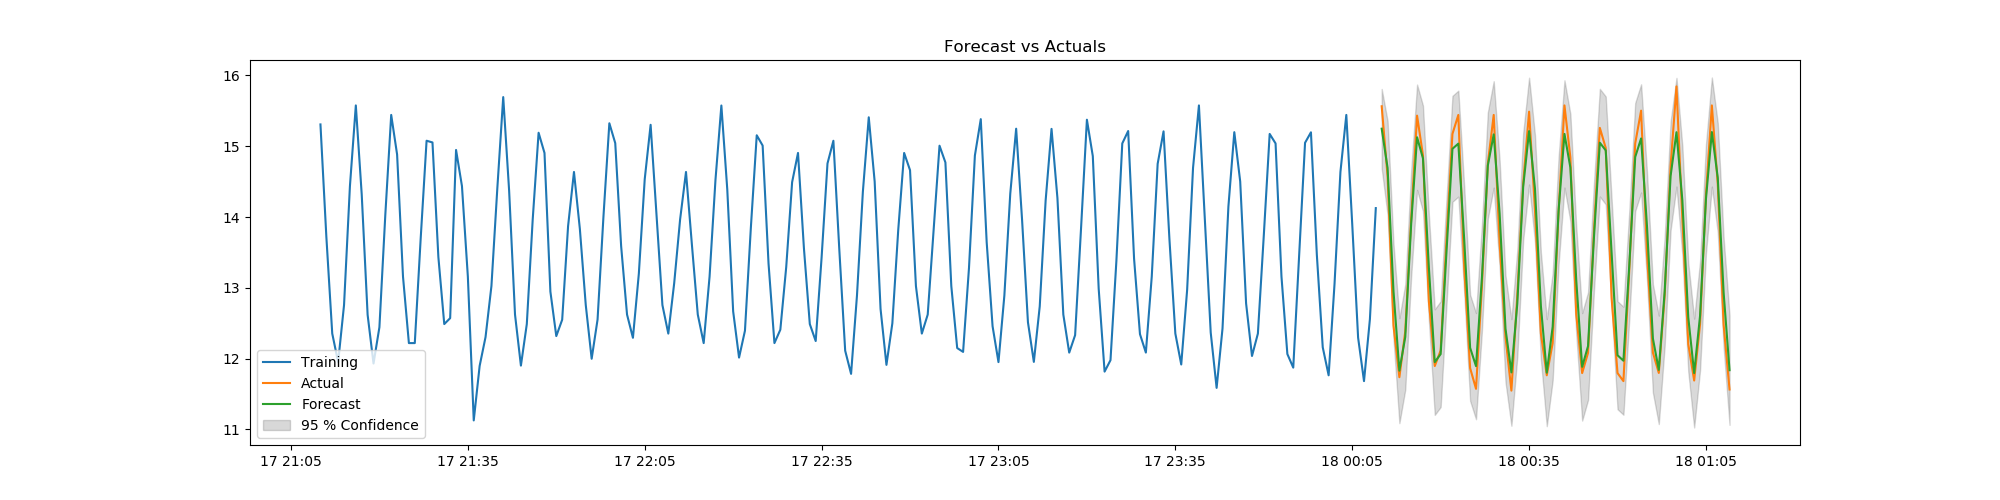

In [76]:
plot = sf.ARIMA_pred(pred_time=60)
display(plot)

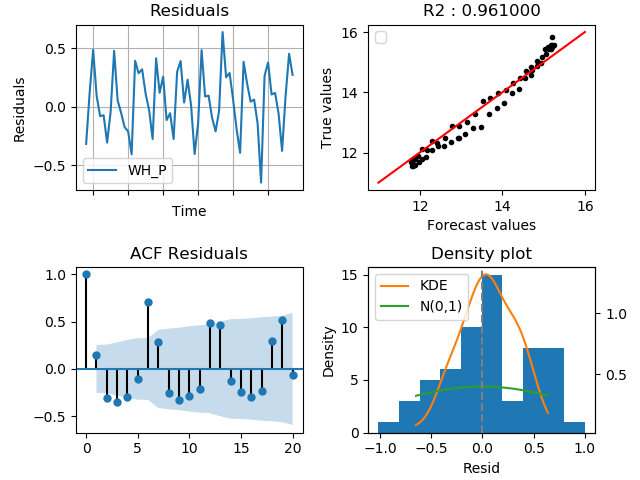

In [77]:
plot = sf.error_metrics_plot(error="pred")
display(plot)

In [78]:
sf.error_metrics(error="pred")

Mean Absolute Percentage Error: 0.551
Mean Squared Error: 0.076000
Root Mean Squared Error: 0.275000
R2 Determination: 0.961000
Out[81]: (0.551, 0.076, 0.275, 0.961)

There is still some cyclicity in the resisduals, as can be observed from the residual plot and the ACF plot. 

Trying with new values for p, the results are obviosuly lower

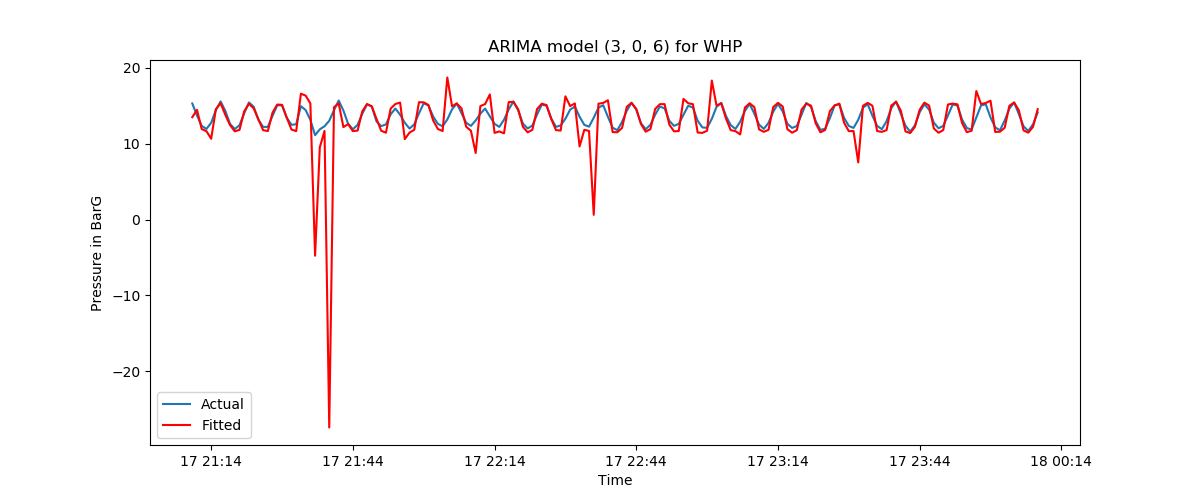

In [80]:
plot = sf.ARIMA_model(3, 0, 6)
display(plot)

For this slug flow, there may not be any better alternatives to the ARIMA fit.